In [3]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

# An efficient data structure. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [4]:
from time import time
from itertools import combinations
from sklearn import preprocessing

import scipy as sp, numpy as np, pandas as pd

def expval(df,col,y,tfilter):
    tmp = pd.DataFrame(index=df.index)
    pb = df[tfilter][y].mean()                                              # train set mean
    tmp['cnt'] = df[col].map(df[tfilter][col].value_counts()).fillna(0)     # train set count
    tmp['csm'] = df[col].map(df[tfilter].groupby(col)[y].sum()).fillna(pb)  # train set sum
    tmp.ix[tfilter,'cnt'] -= 1                                              # reduce count for train set
    tmp.ix[tfilter,'csm'] -= df.ix[tfilter,y]                               # remove current value
    tmp['exp'] = ((tmp.csm+ pb*15) / (tmp.cnt+ 15)).fillna(pb)              # calculate mean including kn-extra 'average' samples 
    np.random.seed(1)
    tmp.ix[tfilter,'exp'] *= 1+.3*(np.random.rand(len(tmp[tfilter]))-.5) # add some random noise to the train set
    return tmp.exp
# Cantor Pairing
def cantor(args):
    # Cantor Pairing - recursive call if more than 1 pair
    if len(args) > 2:
        x2 = cantor(args[1:])
        x1 = args[0]
    else:
        x1, x2 = args
    return int((0.5 * (x1 + x2)*(x1 + x2 + 1) + x2))
# Groups all columns of data into combinations of [degree]
def group_data(data, degree=3, hash=hash, NAMES=None): 
    init = time()
    new_data = []; combined_names = []
    m,n = data.shape
    for indicies in combinations(range(n), degree):
        new_data.append([hash(tuple(v)) for v in data[:,indicies]])
        if NAMES != None:
            combined_names.append( '+'.join([NAMES[indicies[i]] for i in range(degree)]) )
    print ("DONE! %.2fm" % ((time()-init)/60))
    if NAMES != None:
        return (np.array(new_data).T, combined_names)
    return np.array(new_data).T
def concat(df, columns):
    return np.array([''.join(x) for x in np.array(
        [np.array(df[col].values, dtype=str) for col in columns]).T])
def prepare_data(shuffle=True):
    alltest = pd.read_csv('test_session_history.csv')
    test = alltest.set_index('customer_ID')
    alldata = pd.read_csv('train.csv').set_index('customer_ID')

    # separrting features columns
    con = ['group_size','car_age','age_oldest','age_youngest','duration_previous','cost']
    cat = ['homeowner','car_value','risk_factor','married_couple','C_previous','state', 'location','shopping_pt']
    conf = ['policy','cost']; conf_f = [col+'_f' for col in conf]
    extra = []

    final_purchase = alldata[alldata.record_type == 1]          # The Final Puchased Record Seperated
    print("finalpurchase",final_purchase.head())
    
    data = alldata.join(final_purchase[conf], rsuffix='_f')     # Adding the Target Variables from final Purchased record to Session History
    print("data after join",data.head())
    data = data[data.record_type == 0]                          # Taking the Session Records

    data['cost_final'] = data['cost_f']
    data['conf'] = concat(data,conf_f)                          
    data['conf_init'] = concat(data,conf)                       

    encoders = dict()
    data = data.append(test)

    # Fix NAs
    data['C_previous'].fillna(0, inplace=1)
    data['duration_previous'].fillna(0, inplace=1)
    data.location.fillna(-1, inplace=1);
    

    print ('Transforming Location and mapping it:'),
    
    x = data[data.shopping_pt==2].location.value_counts()
    sub = data.location.map(x).fillna(0) < 5
    data.ix[sub,'location'] = data.state[sub]; print ('%.5f' % sub.mean())

    # calculating and checking the cost for important columns
    data['caCost'] = 1.*data.cost / (data.car_age+1)
    data['ppCost'] = 1.*data.cost / data.group_size
    data['stCost'] = data.state.map(data.groupby('state')['cost'].mean())
    extra.extend(['caCost','ppCost','stCost'])

    # mean of the cost per  policy
    data['costG'] = data['policy'].map(data.groupby('policy')['cost'].mean())
    extra.append('costG')

    # mean of the cost per policy & state 
    x = data.groupby(['policy','state'])['cost'].mean()
    x = x.reset_index().set_index(['policy','state']); x.columns = ['costStG']   # covert to DF
    data = data.merge(x,left_on=['policy','state'],right_index=True,how='left')
    extra.append('costStG')

    # finding the pattern in shopping pt,state, policy
    
    grpTrn, c2 = group_data(data[['state','policy','shopping_pt']].values,2,hash,['state','policy','shopping_pt'])
    for i,col in enumerate(c2):
        encoders[col] = preprocessing.LabelEncoder()
   
    extra.extend(c2)

    # mean of the policy per location , state,car_value 
    for col in ['state','location','car_value']:
        extra.append(col+'_exp')
        data[col+'_exp'] = expval(data,col,'policy_f',-data.policy_f.isnull())

    # previous policy calclation
    data['prev_G'] = data.policy.shift(1); extra.append('prev_G')
    data.ix[data.shopping_pt == 1,'prev_G'] = data.ix[data.shopping_pt==1,'policy']

    # finally separating training & test data again
    test = data[data.conf.isnull()]; data = data[-data.conf.isnull()]

    # making the same customers transaction in order
    if shuffle:
        
        np.random.seed(9); ids = np.unique(data.index.values)
        rands = pd.Series(np.random.random_sample(len(ids)),index=ids)
        data['rand'] = data.reset_index()['customer_ID'].map(rands).values
        data.sort_values(['rand','shopping_pt'],inplace=1);

    
    for col in conf_f: data[col] = np.array(data[col].values,dtype=np.int8)
    #reset index again
    data.reset_index()
    test.reset_index()
    return data

In [5]:
data,t,con,cat,extra,conf,conf_f,encoders = prepare_data()

finalpurchase              shopping_pt  record_type  day   time state  location  group_size  \
customer_ID                                                                     
14981                  7            1    3  11:47    OR     40588           1   
261747                 5            1    4  18:40    NV     31780           2   
14987                  8            1    2  12:16    KS     41272           1   
14983                  4            1    4  15:25    NE     33739           1   
261745                 5            1    4  14:42    MO     45796           1   

             homeowner  car_age car_value  risk_factor  age_oldest  \
customer_ID                                                          
14981                0       12         e          NaN          24   
261747               1       12         g          NaN          64   
14987                1        6         e            4          38   
14983                1        3         e          NaN          30  

In [6]:
data.head()

,C_previous,age_oldest,age_youngest,car_age,car_value,conf,conf_init,cost,cost_f,cost_final,...,caCost,ppCost,stCost,costG,costStG,state_exp,location_exp,car_value_exp,prev_G,rand
customer_ID,,,,,,,,,,,,,,,,,,,,,
89271,1,40,40,14,e,3536,3549,549,24,536,...,36.600000,549,619.737271,644.740444,631.366054,2.465694,3.030076,2.452489,3,0.000006
89271,1,40,40,14,e,3536,3536,536,24,536,...,35.733333,536,619.737271,644.740444,631.366054,2.189038,2.690097,2.177315,3,0.000006
89271,1,40,40,14,e,3536,3536,536,24,536,...,35.733333,536,619.737271,644.740444,631.366054,2.141147,2.631243,2.129680,3,0.000006
89271,1,40,40,14,e,3536,3536,536,24,536,...,35.733333,536,619.737271,644.740444,631.366054,1.866103,2.293243,1.856109,3,0.000006
89271,1,40,40,14,e,3536,3536,536,24,536,...,35.733333,536,619.737271,644.740444,631.366054,2.447971,3.008297,2.434861,3,0.000006


In [7]:
#first saving files and after that reading them to work with the index
data.to_csv('preptrn.csv')
t.to_csv('preptest.csv')

In [8]:
data = pd.read_csv('preptrn.csv')



In [9]:
df = data

df = df.loc[df.reset_index().groupby(['customer_ID'])['shopping_pt'].idxmax()]



In [10]:
df.describe()

,customer_ID,C_previous,age_oldest,age_youngest,car_age,conf,conf_init,cost,cost_f,cost_final,...,caCost,ppCost,stCost,costG,costStG,state_exp,location_exp,car_value_exp,prev_G,rand
count,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,...,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000
mean,152720.548113,2.401815,45.070009,42.641399,8.201321,2805.797762,2808.184916,638.224968,3.407446,637.537413,...,116.591514,567.348000,638.578168,638.738071,639.067378,2.174064,2.177196,2.182845,2.165216,0.499758
std,88011.060825,1.073167,17.387224,17.464855,5.779591,955.666820,953.149559,44.362709,97.314255,43.043926,...,103.177084,142.299099,15.472060,6.706024,22.441887,0.574510,0.546678,0.217053,0.945111,0.288625
min,217.000000,0.000000,18.000000,16.000000,0.000000,1400.000000,1393.000000,290.000000,-128.000000,293.000000,...,6.304348,120.333333,598.448454,629.393124,554.337910,0.863012,0.883856,1.284211,1.000000,0.000006
25%,76876.000000,1.000000,29.000000,26.000000,3.000000,1668.000000,1670.000000,608.000000,-99.000000,608.000000,...,49.666667,565.000000,624.186428,629.393124,631.896865,2.075900,1.932408,2.015053,1.000000,0.250036
50%,151795.000000,3.000000,44.000000,40.000000,8.000000,2658.000000,2661.000000,637.000000,42.000000,637.000000,...,75.125000,623.000000,642.487070,640.104863,644.903539,2.328635,2.270266,2.186078,2.000000,0.498260
75%,228876.000000,3.000000,60.000000,57.000000,12.000000,3641.000000,3641.000000,667.000000,99.000000,666.000000,...,146.675000,659.000000,652.372236,644.740444,655.988346,2.557409,2.555087,2.356052,3.000000,0.749644
max,305653.000000,4.000000,75.000000,75.000000,85.000000,4827.000000,4834.000000,869.000000,127.000000,842.000000,...,819.000000,869.000000,663.803262,645.742917,689.121245,3.155253,3.684365,2.757420,4.000000,0.999996


In [11]:

test =  pd.read_csv('preptest.csv')

In [12]:
tst = test

tst = tst.loc[tst.reset_index().groupby(['customer_ID'])['shopping_pt'].idxmax()]

In [13]:
tst.drop(["cost","policy","cost_f"], axis=1, inplace=True)

In [14]:
tst.to_csv('prep_test_final.csv')

In [15]:
df.drop(["cost","policy","cost_f"], axis=1, inplace=True)
df.set_index('customer_ID')
tst.set_index('customer_ID')

,C_previous,age_oldest,age_youngest,car_age,car_value,conf,conf_init,cost_final,day,duration_previous,...,time,caCost,ppCost,stCost,costG,costStG,state_exp,location_exp,car_value_exp,prev_G
customer_ID,,,,,,,,,,,,,,,,,,,,,
207,1,46,42,2,g,NaN,NaN,NaN,0,2,...,8:38,211.000000,316.50,619.722766,644.740444,633.488256,2.341281,2.482517,2.274784,3
221,2,43,43,11,c,NaN,NaN,NaN,4,4,...,8:36,51.583333,619.00,644.147616,629.393124,618.111230,2.299187,1.865058,1.748637,1
235,1,32,28,5,d,NaN,NaN,NaN,4,2,...,16:31,98.000000,588.00,615.294640,644.740444,624.530076,2.569886,2.390947,2.098155,3
239,3,24,24,6,d,NaN,NaN,NaN,2,9,...,13:35,83.857143,587.00,622.373051,645.742917,631.964128,2.386639,2.175321,2.098155,2
263,1,44,20,1,d,NaN,NaN,NaN,5,2,...,15:47,347.500000,347.50,642.487070,644.740444,645.761251,2.598871,2.654973,2.098155,3
281,1,58,58,1,g,NaN,NaN,NaN,5,5,...,9:32,322.500000,645.00,644.147616,645.742917,666.093256,2.299187,2.933248,2.274784,4
287,3,26,26,6,e,NaN,NaN,NaN,2,5,...,11:48,88.428571,619.00,625.466155,644.740444,634.774041,2.743858,2.943006,2.176413,3
317,4,75,75,9,e,NaN,NaN,NaN,3,11,...,14:04,64.100000,641.00,631.878374,644.740444,640.145284,2.423990,2.535242,2.176413,3
361,3,32,32,2,e,NaN,NaN,NaN,4,10,...,14:56,198.666667,596.00,625.466155,645.742917,627.123515,2.743858,2.670498,2.176413,4


In [16]:
df.to_csv('prep_trn_final.csv')

df.describe()

,customer_ID,C_previous,age_oldest,age_youngest,car_age,conf,conf_init,cost_final,day,duration_previous,...,caCost,ppCost,stCost,costG,costStG,state_exp,location_exp,car_value_exp,prev_G,rand
count,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.00000,...,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000,67663.000000
mean,152720.548113,2.401815,45.070009,42.641399,8.201321,2805.797762,2808.184916,637.537413,1.948849,5.92436,...,116.591514,567.348000,638.578168,638.738071,639.067378,2.174064,2.177196,2.182845,2.165216,0.499758
std,88011.060825,1.073167,17.387224,17.464855,5.779591,955.666820,953.149559,43.043926,1.447871,4.70899,...,103.177084,142.299099,15.472060,6.706024,22.441887,0.574510,0.546678,0.217053,0.945111,0.288625
min,217.000000,0.000000,18.000000,16.000000,0.000000,1400.000000,1393.000000,293.000000,0.000000,0.00000,...,6.304348,120.333333,598.448454,629.393124,554.337910,0.863012,0.883856,1.284211,1.000000,0.000006
25%,76876.000000,1.000000,29.000000,26.000000,3.000000,1668.000000,1670.000000,608.000000,1.000000,2.00000,...,49.666667,565.000000,624.186428,629.393124,631.896865,2.075900,1.932408,2.015053,1.000000,0.250036
50%,151795.000000,3.000000,44.000000,40.000000,8.000000,2658.000000,2661.000000,637.000000,2.000000,5.00000,...,75.125000,623.000000,642.487070,640.104863,644.903539,2.328635,2.270266,2.186078,2.000000,0.498260
75%,228876.000000,3.000000,60.000000,57.000000,12.000000,3641.000000,3641.000000,666.000000,3.000000,9.00000,...,146.675000,659.000000,652.372236,644.740444,655.988346,2.557409,2.555087,2.356052,3.000000,0.749644
max,305653.000000,4.000000,75.000000,75.000000,85.000000,4827.000000,4834.000000,842.000000,6.000000,15.00000,...,819.000000,869.000000,663.803262,645.742917,689.121245,3.155253,3.684365,2.757420,4.000000,0.999996


In [17]:
%matplotlib inline

Axes(0.125,0.125;0.775x0.775)


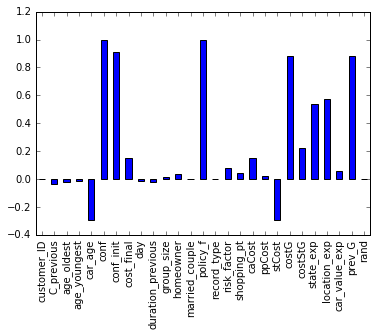

In [18]:
a = pd.DataFrame.from_dict(df, orient='columns')
corr_set = a.corr()
a = corr_set['policy_f']
print (a.plot.bar())

In [19]:
# Look at all the columns in the dataset
def printall(tst, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(tst.to_html(max_rows=max_rows)))
    
printall(tst.describe())

,customer_ID,C_previous,age_oldest,age_youngest,car_age,conf,conf_init,cost_final,day,duration_previous,group_size,homeowner,married_couple,policy_f,record_type,risk_factor,shopping_pt,caCost,ppCost,stCost,costG,costStG,state_exp,location_exp,car_value_exp,prev_G
count,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,0,0,0,29346.000000,29346.000000,29346.00000,29346.000000,29346.000000,0,29346,18667.000000,29346,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000,29346.000000
mean,154693.441082,2.353813,45.155013,42.819907,8.213317,NaN,NaN,NaN,1.946160,5.789409,1.23165,0.548797,0.204798,NaN,0,2.559811,2,115.866024,567.007042,638.563325,638.528481,638.327299,2.174405,2.180660,2.182451,2.097492
std,88296.818499,1.119011,17.435385,17.493880,5.803750,NaN,NaN,NaN,1.449166,4.773281,0.46140,0.497622,0.403561,NaN,0,1.111775,0,102.759688,142.713599,15.400258,6.795838,22.771195,0.541791,0.509567,0.107314,0.945509
min,207.000000,0.000000,18.000000,16.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,1.00000,0.000000,0.000000,NaN,0,1.000000,2,7.772727,134.750000,598.448454,629.393124,554.337910,1.015281,1.038273,1.502514,1.000000
25%,78320.000000,1.000000,29.000000,27.000000,4.000000,NaN,NaN,NaN,1.000000,2.000000,1.00000,0.000000,0.000000,NaN,0,2.000000,2,49.727273,561.000000,625.466155,629.393124,631.495694,2.246192,1.995414,2.176413,1.000000
50%,155650.000000,3.000000,44.000000,40.000000,8.000000,NaN,NaN,NaN,2.000000,4.000000,1.00000,1.000000,0.000000,NaN,0,3.000000,2,74.472222,620.000000,642.487070,640.104863,644.903539,2.345511,2.306548,2.176413,2.000000
75%,231480.000000,3.000000,60.000000,57.000000,12.000000,NaN,NaN,NaN,3.000000,9.000000,1.00000,1.000000,0.000000,NaN,0,4.000000,2,142.500000,659.000000,652.372236,644.740444,654.417266,2.474777,2.540438,2.230369,3.000000
max,305655.000000,4.000000,75.000000,75.000000,74.000000,NaN,NaN,NaN,6.000000,15.000000,4.00000,1.000000,1.000000,NaN,0,4.000000,2,898.000000,898.000000,663.803262,645.742917,689.121245,2.743858,3.254788,2.393963,4.000000


Axes(0.125,0.125;0.775x0.775)


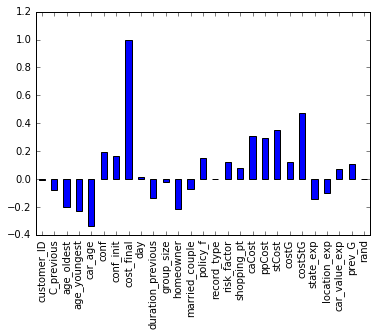

In [20]:
a = pd.DataFrame.from_dict(df, orient='columns')
corr_set = a.corr()
a = corr_set['cost_final']
print (a.plot.bar())

In [122]:
import matplotlib
matplotlib.style.use('ggplot')

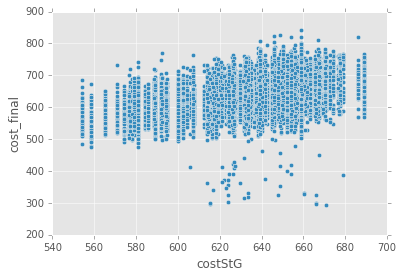

In [150]:
df3 = pd.DataFrame(df, columns=['costStG', 'cost_final'])
# checking the relation between the previous cost , policy, and state
df3.plot.scatter(x='costStG', y='cost_final')

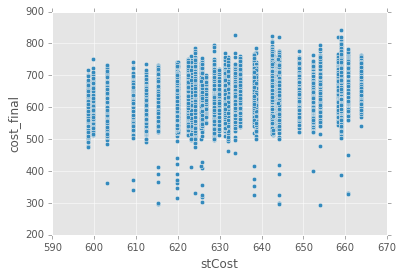

In [149]:
# checking the relation between the mean cost in state and final cost
df3 = pd.DataFrame(df, columns=['stCost', 'cost_final'])

df3.plot.scatter(x='stCost', y='cost_final')

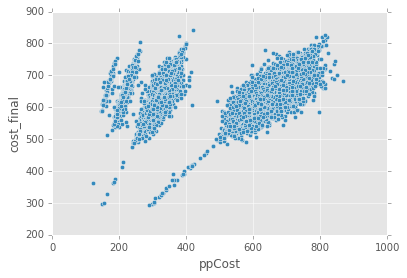

In [147]:
# checking the relation between the cost in per person in group and final cost
df3 = pd.DataFrame(df, columns=['ppCost', 'cost_final'])
df3.plot.scatter(x='ppCost', y='cost_final')

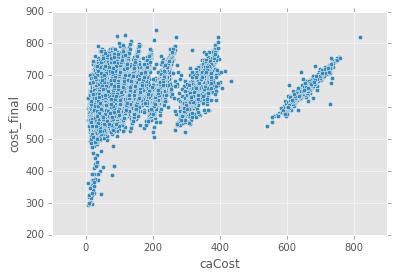

In [151]:
# checking the relation between the car age and final cost
df3 = pd.DataFrame(df, columns=['caCost', 'cost_final'])
df3.plot.scatter(x='caCost', y='cost_final')

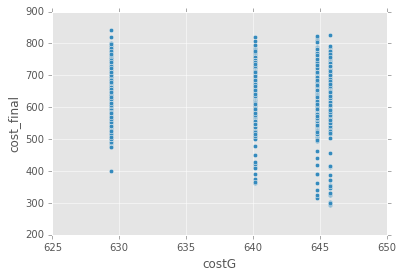

In [152]:
# checking the relation between the car age and final cost
df3 = pd.DataFrame(df, columns=['costG', 'cost_final'])
df3.plot.scatter(x='costG', y='cost_final')

In [21]:
import statsmodels.formula.api as smf

In [25]:

# create a fitted model with all features
lm = smf.ols(formula='cost_final ~ group_size +  stCost + ppCost + caCost + car_age + state_exp + location_exp + policy_f', data=df).fit()


In [26]:
lm.params

Intercept      -243.833407
group_size      180.186271
stCost            0.469914
ppCost            0.627837
caCost            0.019304
car_age          -0.557093
state_exp        -2.885547
location_exp     -0.451518
policy_f          5.727279
dtype: float64

In [27]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             cost_final   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                 1.814e+04
Date:                Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                        16:50:37   Log-Likelihood:            -3.1180e+05
No. Observations:               67663   AIC:                         6.236e+05
Df Residuals:                   67654   BIC:                         6.237e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept     -243.8334      4.751    -51.324      0.000      -253.145  -234.522
group_size     180.1863      0.648    278.072      0.000       178.916   181.456
stCost           0.4699      0.007     65.479      0.000         0.456     0.484
ppCost           0.6278      0.002    298.300      0.000         0.624     0.632
caCost           0.0193      0.001     14.480      0.000         0.017     0.022
car_age         -0.5571      0.025    -22.351      0.000        -0.606    -0.508
state_exp       -2.8855      0.393     -7.338      0.000        -3.656    -2.115
location_exp    -0.4515      0.412     -1.096      0.273        -1.259     0.356
policy_f         5.7273      0.131     43.655      0.000         5.470     5.984
==============================================================================
Omnibus:                    23061.425   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           401285.250
Skew:                          -1.187   Prob(JB):                         0.00
Kurtosis:                      14.692   Cond. No.                     4.42e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
#stCost and ppCost,caCost found important #here R-sq is imp so we remove sme features and try to increase it

In [186]:
# create a fitted model with all features
lm = smf.ols(formula='cost_final ~ duration_previous+age_oldest+ age_youngest + stCost + ppCost + caCost + car_age + policy_f+ state_exp', data=df).fit()


In [187]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             cost_final   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     5147.
Date:                Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                        14:38:26   Log-Likelihood:            -3.3293e+05
No. Observations:               67663   AIC:                         6.659e+05
Df Residuals:                   67653   BIC:                         6.660e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept           -36.1753      6.399     -5.654      0.000       -48.717   -23.634
duration_previous    -1.0237      0.028    -36.103      0.000        -1.079    -0.968
age_oldest            1.1103      0.021     52.791      0.000         1.069     1.152
age_youngest         -1.5038      0.020    -74.794      0.000        -1.543    -1.464
stCost                0.9927      0.010    103.178      0.000         0.974     1.012
ppCost                0.0928      0.001     87.597      0.000         0.091     0.095
caCost                0.0435      0.002     23.965      0.000         0.040     0.047
car_age              -1.1181      0.034    -32.854      0.000        -1.185    -1.051
policy_f             10.0185      0.173     58.073      0.000         9.680    10.357
state_exp            -4.7630      0.293    -16.277      0.000        -5.337    -4.189
==============================================================================
Omnibus:                     3307.829   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12195.174
Skew:                          -0.065   Prob(JB):                         0.00
Kurtosis:                       5.076   Cond. No.                     4.37e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
# create a fitted model with all features
lm = smf.ols(formula='cost_final ~ group_size+ stCost + ppCost + caCost + car_age + policy_f+ state_exp', data=df).fit()


In [30]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             cost_final   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                 2.074e+04
Date:                Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                        16:53:32   Log-Likelihood:            -3.1180e+05
No. Observations:               67663   AIC:                         6.236e+05
Df Residuals:                   67655   BIC:                         6.237e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -243.7817      4.751    -51.315      0.000      -253.093  -234.470
group_size   180.1908      0.648    278.084      0.000       178.921   181.461
stCost         0.4696      0.007     65.481      0.000         0.456     0.484
ppCost         0.6278      0.002    298.309      0.000         0.624     0.632
caCost         0.0193      0.001     14.460      0.000         0.017     0.022
car_age       -0.5575      0.025    -22.372      0.000        -0.606    -0.509
policy_f       5.6927      0.127     44.706      0.000         5.443     5.942
state_exp     -3.2468      0.214    -15.161      0.000        -3.667    -2.827
==============================================================================
Omnibus:                    23064.477   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           401282.740
Skew:                          -1.187   Prob(JB):                         0.00
Kurtosis:                      14.692   Cond. No.                     4.42e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
# create a fitted model with all features
lm = smf.ols(formula='cost_final ~ group_size+ppCost + car_age + policy_f+ state_exp', data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             cost_final   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                 2.637e+04
Date:                Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                        16:54:58   Log-Likelihood:            -3.1399e+05
No. Observations:               67663   AIC:                         6.280e+05
Df Residuals:                   67657   BIC:                         6.280e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     40.0535      2.071     19.344      0.000        35.995    44.112
group_size   191.0553      0.648    295.024      0.000       189.786   192.325
ppCost         0.6643      0.002    316.460      0.000         0.660     0.668
car_age       -0.8873      0.018    -48.464      0.000        -0.923    -0.851
policy_f       4.5863      0.130     35.240      0.000         4.331     4.841
state_exp     -8.1469      0.207    -39.405      0.000        -8.552    -7.742
==============================================================================
Omnibus:                    26278.209   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           530540.091
Skew:                          -1.373   Prob(JB):                         0.00
Kurtosis:                      16.440   Cond. No.                     1.31e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
# create a fitted model with all features
lm = smf.ols(formula='cost_final ~ group_size+ stCost + ppCost + caCost + car_age', data=df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             cost_final   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                 2.777e+04
Date:                Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                        16:56:24   Log-Likelihood:            -3.1282e+05
No. Observations:               67663   AIC:                         6.256e+05
Df Residuals:                   67657   BIC:                         6.257e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -207.2955      4.063    -51.021      0.000      -215.259  -199.332
group_size   184.1569      0.652    282.547      0.000       182.879   185.434
stCost         0.4065      0.006     63.855      0.000         0.394     0.419
ppCost         0.6414      0.002    303.274      0.000         0.637     0.646
caCost         0.0137      0.001     10.174      0.000         0.011     0.016
car_age       -0.9013      0.024    -37.418      0.000        -0.949    -0.854
==============================================================================
Omnibus:                    24006.398   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           430505.132
Skew:                          -1.245   Prob(JB):                         0.00
Kurtosis:                      15.104   Cond. No.                     3.72e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
# create a fitted model with all features
lm = smf.ols(formula='cost_final ~group_size + duration_previous + age_oldest + age_youngest + stCost + ppCost + caCost+ car_age + policy_f + state_exp', data=df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             cost_final   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                 1.504e+04
Date:                Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                        17:14:54   Log-Likelihood:            -3.1098e+05
No. Observations:               67663   AIC:                         6.220e+05
Df Residuals:                   67652   BIC:                         6.221e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept          -249.9137      4.705    -53.112      0.000      -259.136  -240.691
group_size          177.2315      0.713    248.546      0.000       175.834   178.629
duration_previous    -0.4603      0.021    -22.318      0.000        -0.501    -0.420
age_oldest           -0.2560      0.016    -15.834      0.000        -0.288    -0.224
age_youngest          0.1048      0.016      6.584      0.000         0.074     0.136
stCost                0.5166      0.007     71.609      0.000         0.503     0.531
ppCost                0.6091      0.002    275.117      0.000         0.605     0.613
caCost                0.0182      0.001     13.847      0.000         0.016     0.021
car_age              -0.6048      0.025    -24.496      0.000        -0.653    -0.556
policy_f              5.7319      0.126     45.523      0.000         5.485     5.979
state_exp            -2.9609      0.212    -13.987      0.000        -3.376    -2.546
==============================================================================
Omnibus:                    21964.720   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           364771.828
Skew:                          -1.123   Prob(JB):                         0.00
Kurtosis:                      14.151   Cond. No.                     4.44e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""